### Packages importing

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor, plot_importance

sys.path.append(os.path.dirname(os.getcwd()))

### Data load

We will use information from two dataset, one containing data about the trips and the other storing zoning information about the different areas of the city of New York. THe information that we will allow to link the two is the PULocationID code and DOLocationID drom the first dataset and the LocationID from the late.

In [2]:
df = pd.read_parquet(
    "D://FinalProject//dataset//yellow_tripdata_2022-05.parquet"
)  ##change the path for your own local
df.sample(10, random_state=42)  # seed of randomness for reproducibility

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
3043622         2  2022-05-27 16:45:16   2022-05-27 16:52:08              1.0   
208456          1  2022-05-03 10:01:56   2022-05-03 10:19:06              1.0   
942942          1  2022-05-09 16:59:46   2022-05-09 17:03:47              1.0   
247636          2  2022-05-03 16:30:52   2022-05-03 16:41:19              1.0   
3052006         2  2022-05-27 18:45:16   2022-05-27 18:53:46              1.0   
1291561         2  2022-05-12 15:22:00   2022-05-12 15:29:22              5.0   
3073378         2  2022-05-27 21:24:03   2022-05-27 21:32:10              4.0   
3423926         2  2022-05-31 18:53:00   2022-05-31 19:03:35              1.0   
3486168         2  2022-05-06 18:40:00   2022-05-06 18:44:00              NaN   
778070          2  2022-05-07 22:12:17   2022-05-07 22:24:17              2.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
3043622           0.90         1.0                  N           249   
208456            0.80         1.0                  N           141   
942942            0.70         1.0                  N           151   
247636            1.72         1.0                  N            87   
3052006           1.54         1.0                  N            42   
1291561           1.03         1.0                  N           107   
3073378           1.19         1.0                  N           161   
3423926           1.78         1.0                  N           163   
3486168           0.83         NaN               None            87   
778070            1.68         1.0                  N           161   

         DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
3043622           114             1          6.0    1.0      0.5        2.06   
208456            141             2          6.5    2.5      0.5        0.00   
942942            238             1          5.0    3.5      0.5        1.85   
247636            148             1          8.5    1.0      0.5        2.56   
3052006            24             1          8.0    1.0      0.5        1.96   
1291561           234             1          6.5    0.0      0.5        1.00   
3073378            48             1          7.0    0.5      0.5        2.16   
3423926           234             1          9.0    1.0      0.5        2.66   
3486168            45             0         10.0    0.0      0.5        2.00   
778070            107             2          9.5    0.5      0.5        0.00   

         tolls_amount  improvement_surcharge  total_amount  \
3043622           0.0                    0.3         12.36   
208456            0.0                    0.3          9.80   
942942            0.0                    0.3         11.15   
247636            0.0                    0.3         15.36   
3052006           0.0                    0.3         11.76   
1291561           0.0                    0.3         10.80   
3073378           0.0                    0.3         12.96   
3423926           0.0                    0.3         15.96   
3486168           0.0                    0.3         15.30   
778070            0.0                    0.3         13.30   

         congestion_surcharge  airport_fee  
3043622                   2.5          0.0  
208456                    2.5          0.0  
942942                    2.5          0.0  
247636                    2.5          0.0  
3052006                   0.0          0.0  
1291561                   2.5          0.0  
3073378                   2.5          0.0  
3423926                   2.5          0.0  
3486168                   NaN          NaN  
778070                    2.5          0.0

In [3]:
df2 = pd.read_csv("D://FinalProject//dataset//taxi+_zone_lookup.csv")

In [4]:
# Auxiliary datasets creation
df_pickup = pd.merge(df, df2, left_on="PULocationID", right_on="LocationID")
df_dropoff = pd.merge(df, df2, left_on="DOLocationID", right_on="LocationID")

In [5]:
# Compose of the final working dataset
df["PUZone"] = df_pickup["Zone"]
df["DOZone"] = df_dropoff["Zone"]

In [6]:
df3 = pd.read_csv("D://FinalProject//dataset//taxi_zone_lookup_coordinates.csv")

In [7]:
# Auxiliary datasets creation
df_lat_pickup = pd.merge(df, df3, left_on="PULocationID", right_on="LocationID")
df_lat_dropoff = pd.merge(df, df3, left_on="DOLocationID", right_on="LocationID")

In [8]:
# Compose of the final working dataset
df["PULat"] = df_lat_pickup["latitude"]
df["PULong"] = df_lat_pickup["longitude"]
df["DOLat"] = df_lat_dropoff["latitude"]
df["DOLong"] = df_lat_dropoff["longitude"]

### Descriptive analysis

In [9]:
print(f"This dataset is composed of {df.shape[0]} rows and {df.shape[1]} columns")

This dataset is composed of 3588295 rows and 25 columns


Since the dataset its extensive and modeling it's gonna consume a lot of hardware, we will work with a subsample.

In [10]:
df_subset = df.sample(10000, random_state=42)  # seed of randomness for reproducibility

In [11]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 3043622 to 1089672
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               10000 non-null  int64         
 1   tpep_pickup_datetime   10000 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  10000 non-null  datetime64[ns]
 3   passenger_count        9633 non-null   float64       
 4   trip_distance          10000 non-null  float64       
 5   RatecodeID             9633 non-null   float64       
 6   store_and_fwd_flag     9633 non-null   object        
 7   PULocationID           10000 non-null  int64         
 8   DOLocationID           10000 non-null  int64         
 9   payment_type           10000 non-null  int64         
 10  fare_amount            10000 non-null  float64       
 11  extra                  10000 non-null  float64       
 12  mta_tax                10000 non-null  float64       
 13

We have a combination of datetime, integer and float type of variables with a few object type. We will have to deal somehow with the latter.

### Check for unique values and na's

In [12]:
df_subset.isna().sum() / df_subset.shape[0] * 100

VendorID                 0.00
tpep_pickup_datetime     0.00
tpep_dropoff_datetime    0.00
passenger_count          3.67
trip_distance            0.00
RatecodeID               3.67
store_and_fwd_flag       3.67
PULocationID             0.00
DOLocationID             0.00
payment_type             0.00
fare_amount              0.00
extra                    0.00
mta_tax                  0.00
tip_amount               0.00
tolls_amount             0.00
improvement_surcharge    0.00
total_amount             0.00
congestion_surcharge     3.67
airport_fee              3.67
PUZone                   0.31
DOZone                   0.37
PULat                    1.38
PULong                   0.31
DOLat                    1.09
DOLong                   0.37
dtype: float64

Very few null values, so they can be taken out of the dataset without losing much information.

In [13]:
df.nunique() / df.shape[0] * 100

VendorID                  0.000111
tpep_pickup_datetime     48.900968
tpep_dropoff_datetime    48.849635
passenger_count           0.000279
trip_distance             0.132960
RatecodeID                0.000195
store_and_fwd_flag        0.000056
PULocationID              0.007218
DOLocationID              0.007274
payment_type              0.000139
fare_amount               0.226821
extra                     0.001700
mta_tax                   0.000362
tip_amount                0.105315
tolls_amount              0.021431
improvement_surcharge     0.000084
total_amount              0.400720
congestion_surcharge      0.000195
airport_fee               0.000084
PUZone                    0.007162
DOZone                    0.007218
PULat                     0.006856
PULong                    0.006828
DOLat                     0.006911
DOLong                    0.006883
dtype: float64

We can say that we dont have a lot of variability in the dataset, except for two variables that will be transformed in the next step.

### Creation of a "duration" variable

One of the aims of the projects it's to predict duration of the trips, so we will create the duration variable, containing the information pertaining how much (in minutes) a trip lasted, calculating a diference between trip drop-off and pick up, as it follows:

We will convert trip_distance variable from miles to kilometers, since it will allow us to make a clear faster interpretation of the next sections.

In [14]:
df_subset["duration"] = (
    df_subset["tpep_dropoff_datetime"] - df_subset["tpep_pickup_datetime"]
)
df_subset["duration"] = df_subset["duration"].dt.total_seconds() / 60

In [15]:
df_subset["trip_distance"] = (
    df_subset["trip_distance"] * 1.61
)  ### Convertion rate: 1 mile is about 1.61 kilometers.

In [16]:
round(df_subset.describe(), 2)

VendorID           tpep_pickup_datetime          tpep_dropoff_datetime  \
count  10000.00                          10000                          10000   
mean       1.72  2022-05-16 07:09:26.502500096  2022-05-16 07:27:44.178500096   
min        1.00            2022-05-01 00:01:27            2022-05-01 00:02:44   
25%        1.00     2022-05-08 16:53:01.500000  2022-05-08 17:18:51.249999872   
50%        2.00     2022-05-16 10:53:04.500000     2022-05-16 11:12:57.500000   
75%        2.00            2022-05-23 15:54:47            2022-05-23 16:32:44   
max        6.00            2022-05-31 23:53:48            2022-06-01 14:08:34   
std        0.48                            NaN                            NaN   

       passenger_count  trip_distance  RatecodeID  PULocationID  DOLocationID  \
count          9633.00       10000.00     9633.00      10000.00      10000.00   
mean              1.41           5.89        1.35        164.59        162.12   
min               0.00           0.00        1.00          1.00          1.00   
25%               1.00           1.85        1.00        132.00        113.00   
50%               1.00           3.22        1.00        162.00        162.00   
75%               2.00           6.01        1.00        234.00        234.00   
max               6.00          95.76       99.00        265.00        265.00   
std               0.96           7.38        5.10         65.72         70.05   

       payment_type  fare_amount  ...  tolls_amount  improvement_surcharge  \
count      10000.00     10000.00  ...      10000.00               10000.00   
mean           1.18        15.26  ...          0.57                   0.30   
min            0.00       -65.50  ...        -13.75                  -0.30   
25%            1.00         7.00  ...          0.00                   0.30   
50%            1.00        10.50  ...          0.00                   0.30   
75%            1.00        17.00  ...          0.00                   0.30   
max            4.00       300.00  ...         86.00                   0.30   
std            0.50        14.49  ...          2.19                   0.05   

       total_amount  congestion_surcharge  airport_fee    PULat   PULong  \
count      10000.00               9633.00      9633.00  9862.00  9969.00   
mean          22.23                  2.29         0.10    40.75   -74.42   
min          -68.55                 -2.50        -1.25    40.51  -116.66   
25%           12.36                  2.50         0.00    40.74   -73.99   
50%           16.30                  2.50         0.00    40.75   -73.98   
75%           23.76                  2.50         0.00    40.77   -73.96   
max          314.05                  2.50         1.25    42.19   -71.20   
std           18.15                  0.73         0.34     0.05     4.40   

         DOLat   DOLong  duration  
count  9891.00  9963.00  10000.00  
mean     40.76   -74.27     18.29  
min      40.58  -116.66     -0.65  
25%      40.74   -73.99      7.77  
50%      40.76   -73.98     12.72  
75%      40.77   -73.96     20.40  
max      42.45   -71.20   1438.78  
std       0.06     3.62     52.13  

[8 rows x 23 columns]

### EDA graphical phase

- Plot for datetime type of variables

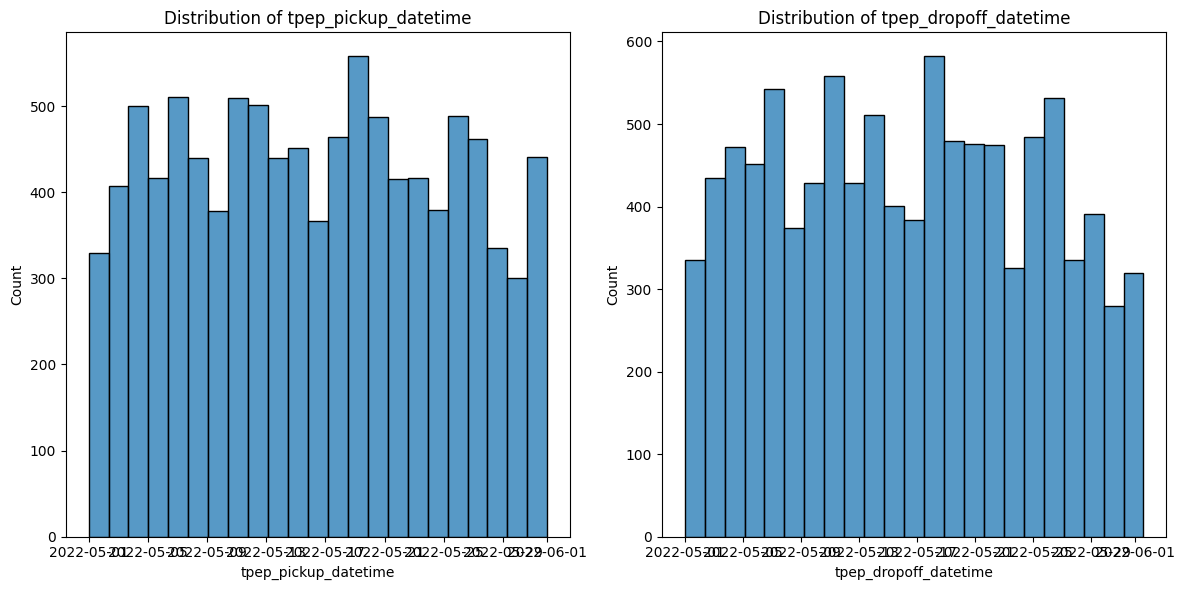

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Histogram for 'pickup_time' in the first subplot
sns.histplot(data=df_subset, x="tpep_pickup_datetime", ax=axes[0])
axes[0].set_title("Distribution of tpep_pickup_datetime")
# Histogram for 'drop_time' in the second subplot
sns.histplot(data=df_subset, x="tpep_dropoff_datetime", ax=axes[1])
axes[1].set_title("Distribution of tpep_dropoff_datetime")
# Adjust spacing between subplots
plt.tight_layout()

plt.show()

- Plots for numerical variables

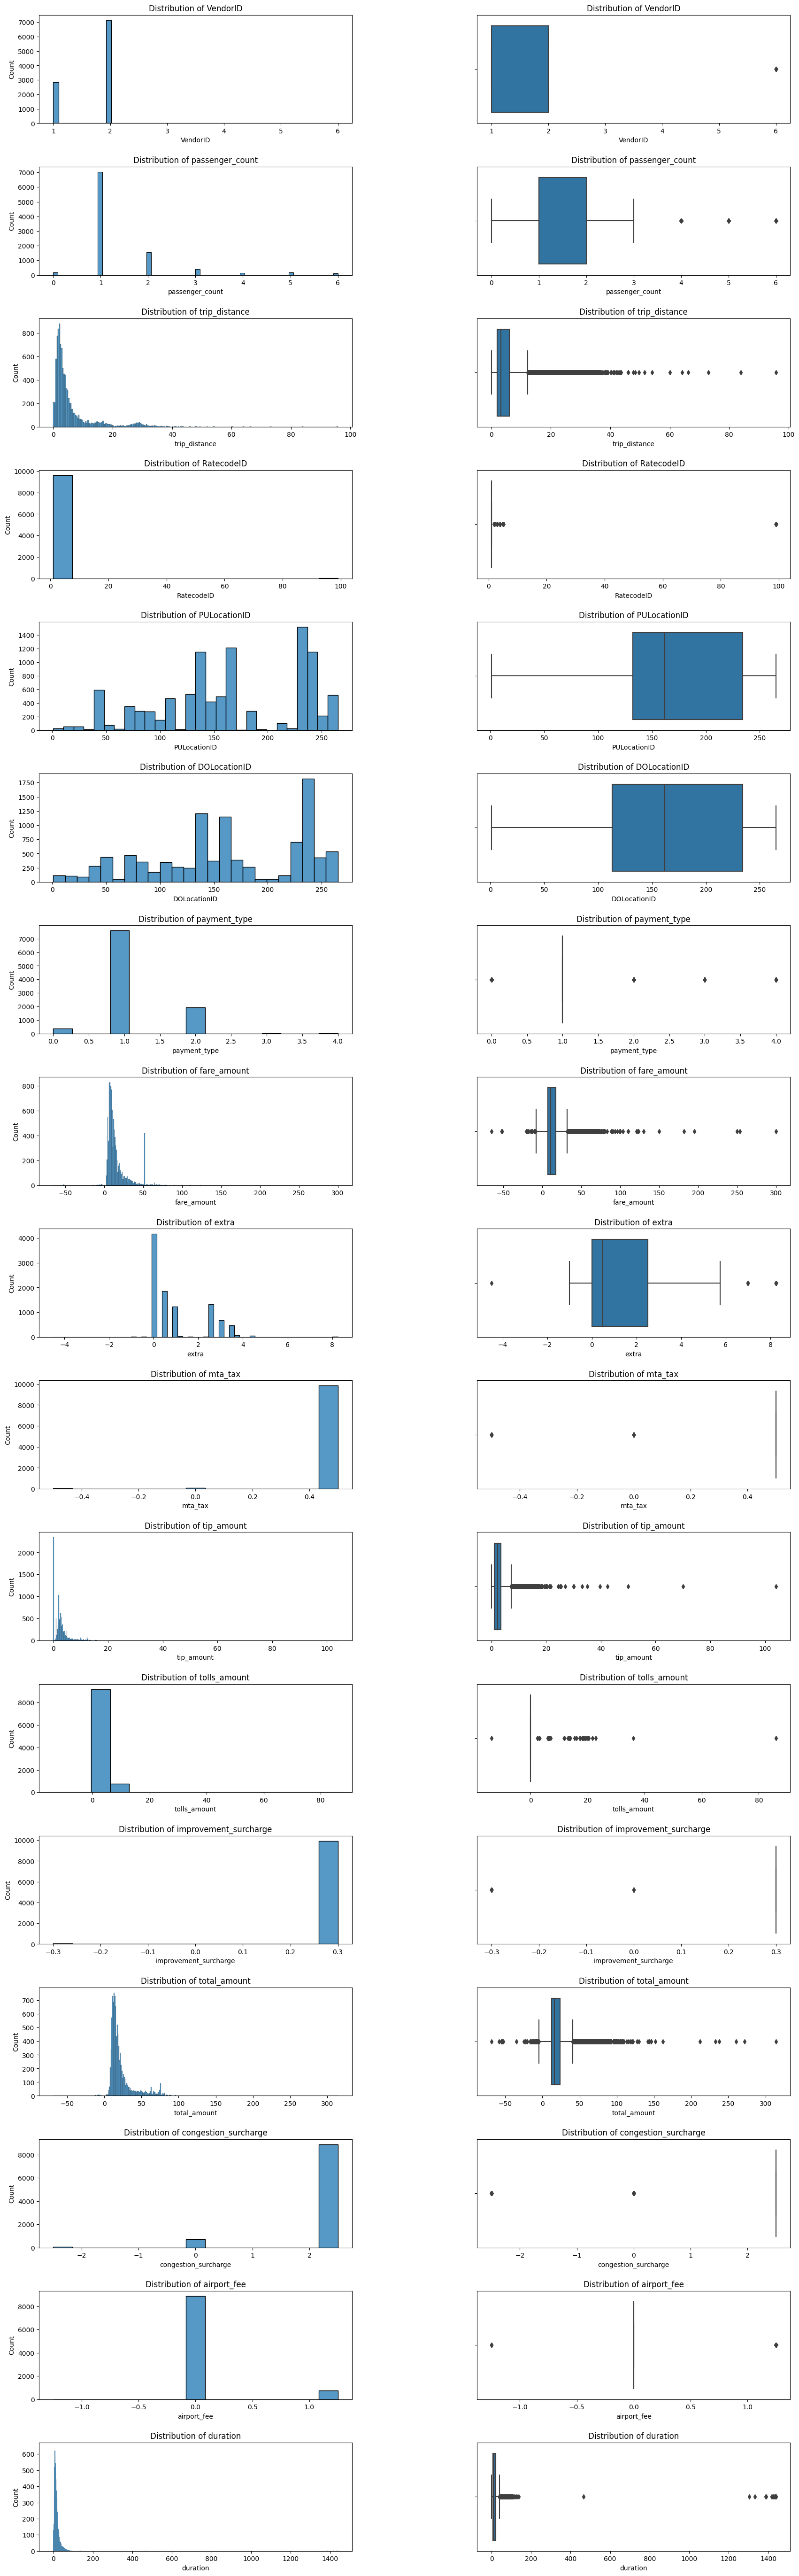

In [18]:
columns = df_subset.drop(
    [
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "store_and_fwd_flag",
        "PUZone",
        "DOZone",
        "PUZone",
        "DOZone",
        "PULat",
        "PULong",
        "DOLat",
        "DOLong",
    ],
    axis=1,
).columns
fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(20, 60))

for index, col in enumerate(columns):
    axes[index][0].set_title(f"Distribution of {col}")
    sns.histplot(x=df_subset[col], ax=axes[index][0])
    axes[index][1].set_title(f"Distribution of {col}")
    sns.boxplot(x=df_subset[col], ax=axes[index][1])

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1, wspace=0.4, hspace=0.4)
plt.show()

Many of our numerical variables have negative values and outliers, which are defined in this notebook as the observation that lies an abnormal distance from a Q1/Q3 +- 1.5 IQR. We have a lot of work to do. Will deal with this values in the next section.

Now knowing that the dataset contains variables that are not informative, we will drop the variables "Vendor ID" (just codifies the company on wich the cellphone works), "RatecodeID" (predominant fixed rate codified with the number 1) and "payment_type" (just code the customers prefered payment type and there is an overrepresentaion of cash).

In [19]:
df_subset = df_subset.drop(["VendorID", "payment_type", "RatecodeID"], axis=1)

- Now, plots for object type of variables

Since both Pick up and Drop off zone have a lot of unique values [1], in order to make an accesible and understandable plot, we are going to group each one of these two object type variables in ad-hoc dataframes and plot the 10 most frequent as it follows.

In [20]:
# [1]
df_subset["PUZone"].nunique(), df_subset["DOZone"].nunique()

(140, 204)

In [21]:
# Auxiliary grouping dataframes
grouping_PU_df = pd.DataFrame(
    df_subset["PUZone"].value_counts().sort_values(ascending=False).head(10)
)
grouping_DO_df = pd.DataFrame(
    df_subset["DOZone"].value_counts().sort_values(ascending=False).head(10)
)

In [22]:
# Index reset
grouping_PU_df.reset_index(inplace=True)
grouping_PU_df = grouping_PU_df.rename(columns={"index": "new column name"})
grouping_DO_df.reset_index(inplace=True)
grouping_DO_df = grouping_DO_df.rename(columns={"index": "new column name"})

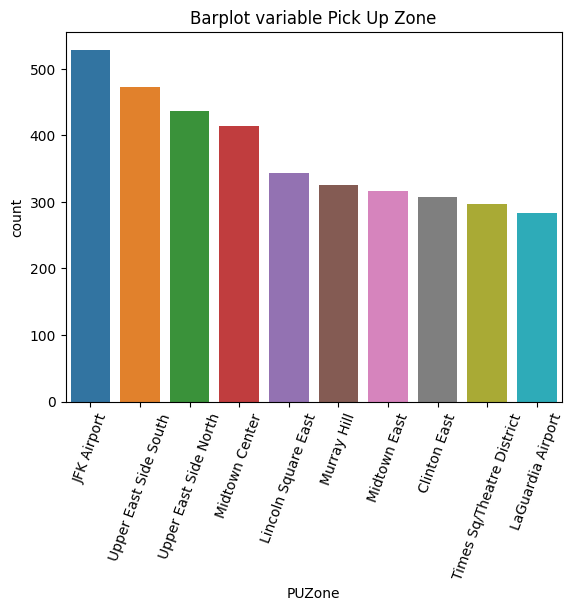

In [23]:
# Plot PUZone
fig = plt.figure()
ax = plt.axes()
ax = sns.barplot(
    x=grouping_PU_df["PUZone"], y=grouping_PU_df["count"], data=grouping_PU_df
)
plt.xticks(rotation=70)
plt.title("Barplot variable Pick Up Zone")
plt.show()

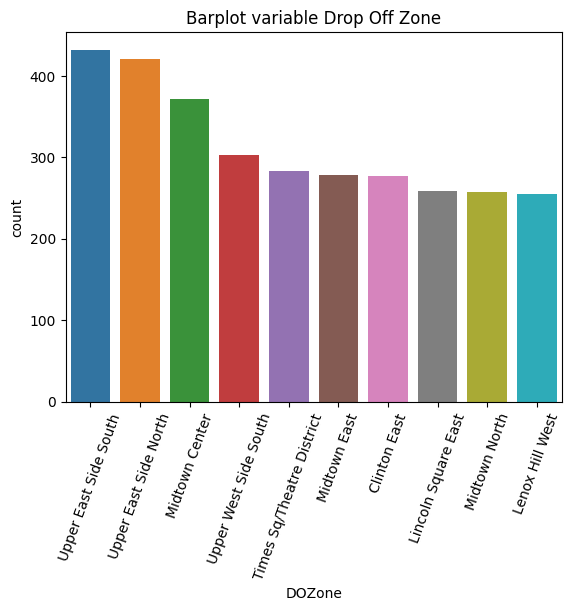

In [24]:
# Plot DOZone
fig = plt.figure()
ax = plt.axes()
ax = sns.barplot(
    x=grouping_DO_df["DOZone"], y=grouping_DO_df["count"], data=grouping_DO_df
)
plt.xticks(rotation=70)
plt.title("Barplot variable Drop Off Zone")
plt.show()

Lastly, we will drop the variable "store_and_fwd_flag" based on the information contained in the data dictionary informing that this variable only contains information in the data of the trip was stored or sent at the end of the trip.

In [25]:
df_subset = df_subset.drop(["store_and_fwd_flag"], axis=1)

### Na's drop

We will start to clean our dataset and variables of null values and outliers in order to develop better estimators and performant algorithms.

In [26]:
filtered_df = df_subset.dropna()

### Outliers detection

In [46]:
def outliers_detection(variable):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(variable)
    axes[0].hist(filtered_df[variable])
    axes[1].boxplot(filtered_df[variable])
    plt.show()
    percentile_25 = np.percentile(filtered_df[variable], 25)
    percentile_50 = np.percentile(filtered_df[variable], 50)
    percentile_75 = np.percentile(filtered_df[variable], 75)
    print(f"mín = {filtered_df[variable].min()}")
    print(f"Percentile 0.25 = {percentile_25}")
    print(f"Percentile 0.50 = {percentile_25}")
    print(f"Percentile 0.75 = {percentile_75}")
    print(f"max = {filtered_df[variable].max()}")

- Passenger count (erase the observation with value 0)
- Trip distance
- Rate code id (there is one observation with code of 90)
- Fare amount (erase negatives and > 200)
- Extra (erase negatives)
- Mta. Tax (erase negatives)
- Tolls (erase negatives)
- Improvement (erase negatives)
- Airport fee
- Congestion (erase negatives)

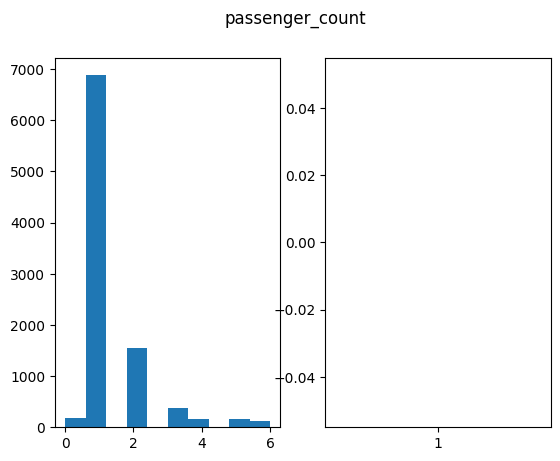

mín = 0.0
Percentile 0.25 = 1.0
Percentile 0.50 = 1.0
Percentile 0.75 = 2.0
max = 6.0


In [28]:
outliers_detection("passenger_count")

In [29]:
filtered_df = filtered_df[
    (filtered_df["passenger_count"] > 0) & (filtered_df["passenger_count"] <= 4)
]
filtered_df.shape

(8955, 22)

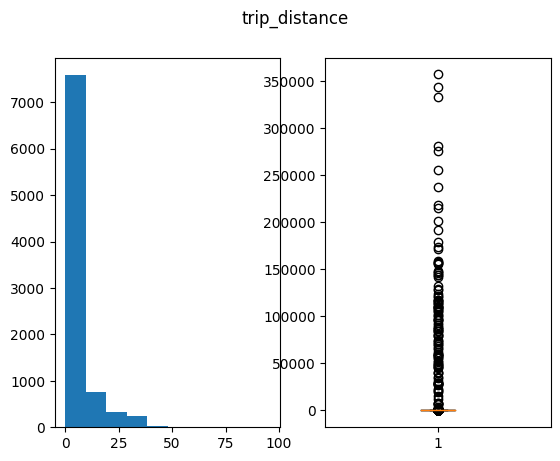

mín = 0.0
Percentile 0.25 = 1.8354
Percentile 0.50 = 1.8354
Percentile 0.75 = 5.836250000000001
max = 95.7628


In [30]:
outliers_detection("trip_distance")

In [31]:
filtered_df = filtered_df[filtered_df["trip_distance"] > 0]
filtered_df = filtered_df[filtered_df["trip_distance"] < 50]
filtered_df.shape

(8819, 22)

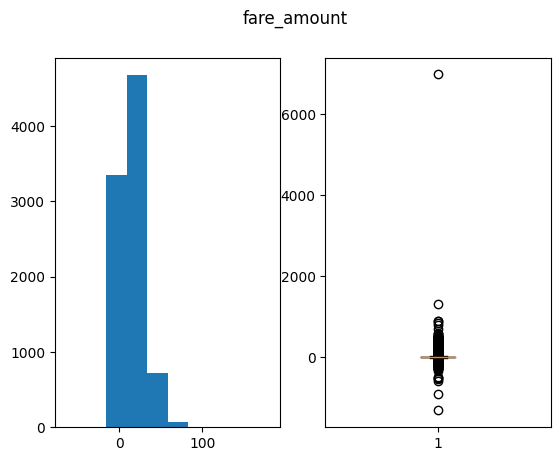

mín = -65.5
Percentile 0.25 = 7.0
Percentile 0.50 = 7.0
Percentile 0.75 = 16.1
max = 182.0


In [32]:
outliers_detection("fare_amount")

In [33]:
filtered_df = filtered_df[
    (filtered_df["fare_amount"] < 90) & (filtered_df["fare_amount"] > 0)
]
filtered_df.shape

(8760, 22)

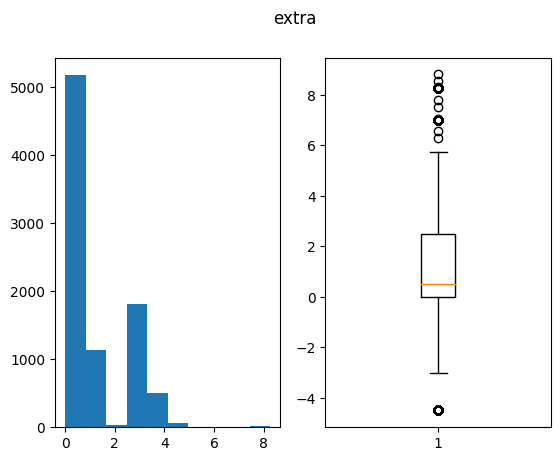

mín = 0.0
Percentile 0.25 = 0.0
Percentile 0.50 = 0.0
Percentile 0.75 = 2.5
max = 8.25


In [34]:
outliers_detection("extra")

In [35]:
filtered_df = filtered_df[filtered_df["extra"] < 6]
filtered_df.shape

(8742, 22)

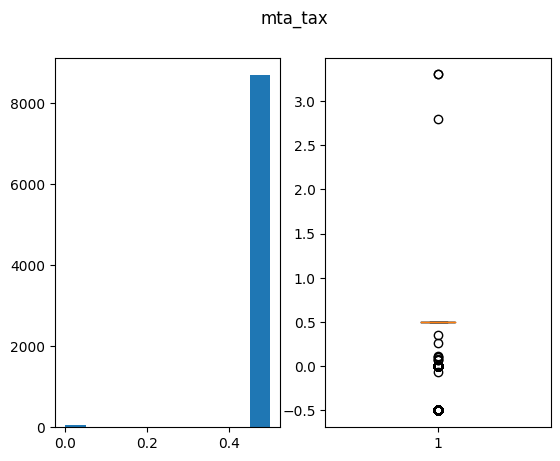

mín = 0.0
Percentile 0.25 = 0.5
Percentile 0.50 = 0.5
Percentile 0.75 = 0.5
max = 0.5


In [36]:
outliers_detection("mta_tax")

Based on the last graph, the variable "mta_tax" doesn't have a lot of variability so we can safely assume that it's not informative and we can drop it from our dataframe without losing information.

In [37]:
filtered_df = filtered_df.drop("mta_tax", axis=1)

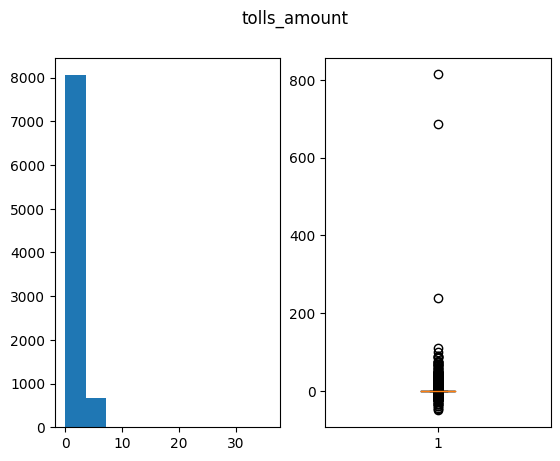

mín = 0.0
Percentile 0.25 = 0.0
Percentile 0.50 = 0.0
Percentile 0.75 = 0.0
max = 36.0


In [38]:
outliers_detection("tolls_amount")

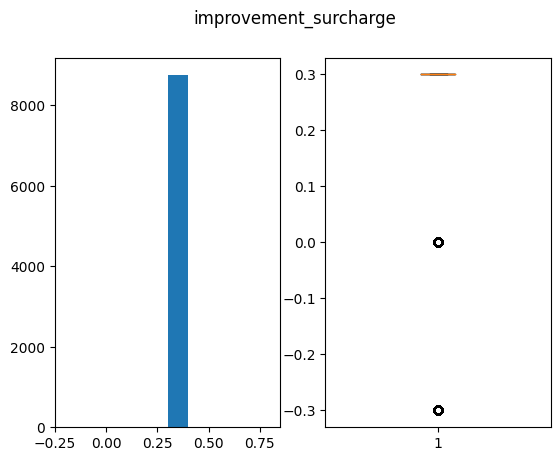

mín = 0.3
Percentile 0.25 = 0.3
Percentile 0.50 = 0.3
Percentile 0.75 = 0.3
max = 0.3


In [39]:
outliers_detection("improvement_surcharge")

Based on the histogram and the data dictionary, "improvement_surcharge" doesn't contain variation. We can drop it without losing information in our dataset.

In [40]:
filtered_df = filtered_df.drop("improvement_surcharge", axis=1)

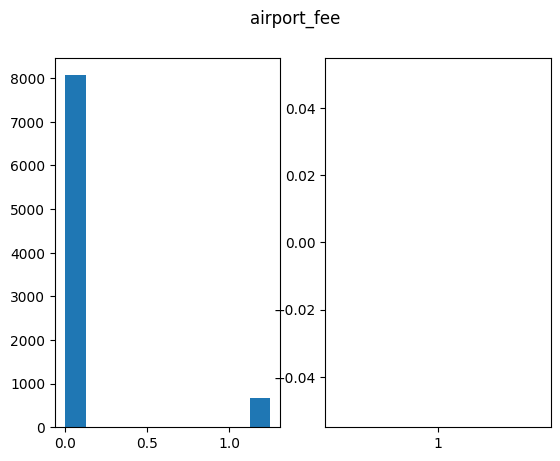

mín = 0.0
Percentile 0.25 = 0.0
Percentile 0.50 = 0.0
Percentile 0.75 = 0.0
max = 1.25


In [41]:
outliers_detection("airport_fee")

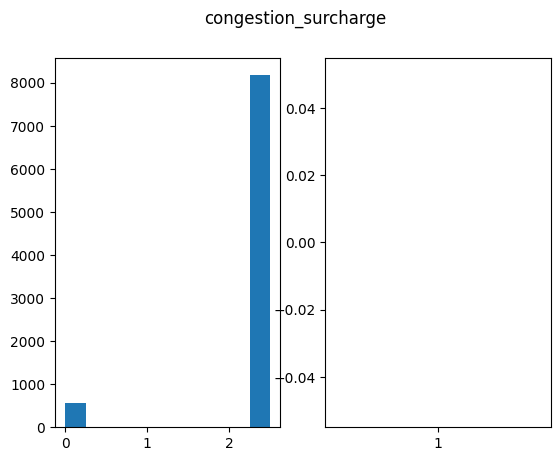

mín = 0.0
Percentile 0.25 = 2.5
Percentile 0.50 = 2.5
Percentile 0.75 = 2.5
max = 2.5


In [42]:
outliers_detection("congestion_surcharge")

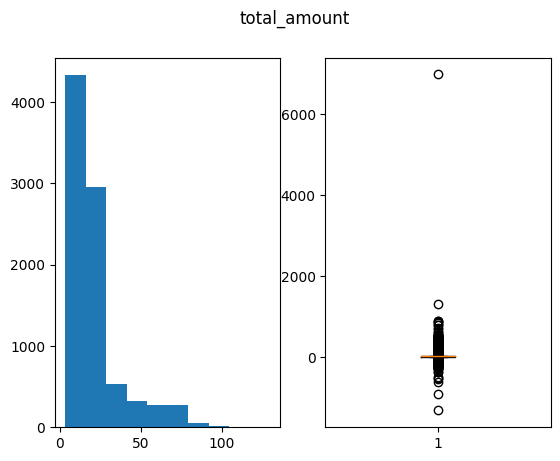

mín = 3.3
Percentile 0.25 = 12.36
Percentile 0.50 = 12.36
Percentile 0.75 = 22.8
max = 129.95


In [43]:
outliers_detection("total_amount")

In [44]:
filtered_df = filtered_df[filtered_df["total_amount"] > 0]
filtered_df.shape

(8742, 20)

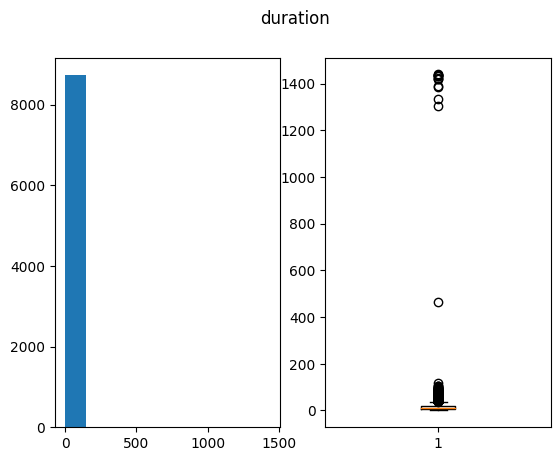

mín = 0.0
Percentile 0.25 = 7.883333333333334
Percentile 0.50 = 7.883333333333334
Percentile 0.75 = 20.083333333333332
max = 1438.7833333333333


In [47]:
outliers_detection("duration")

In [ ]:
filtered_df = filtered_df[filtered_df["duration"] > 0]
filtered_df.shape

(8741, 20)

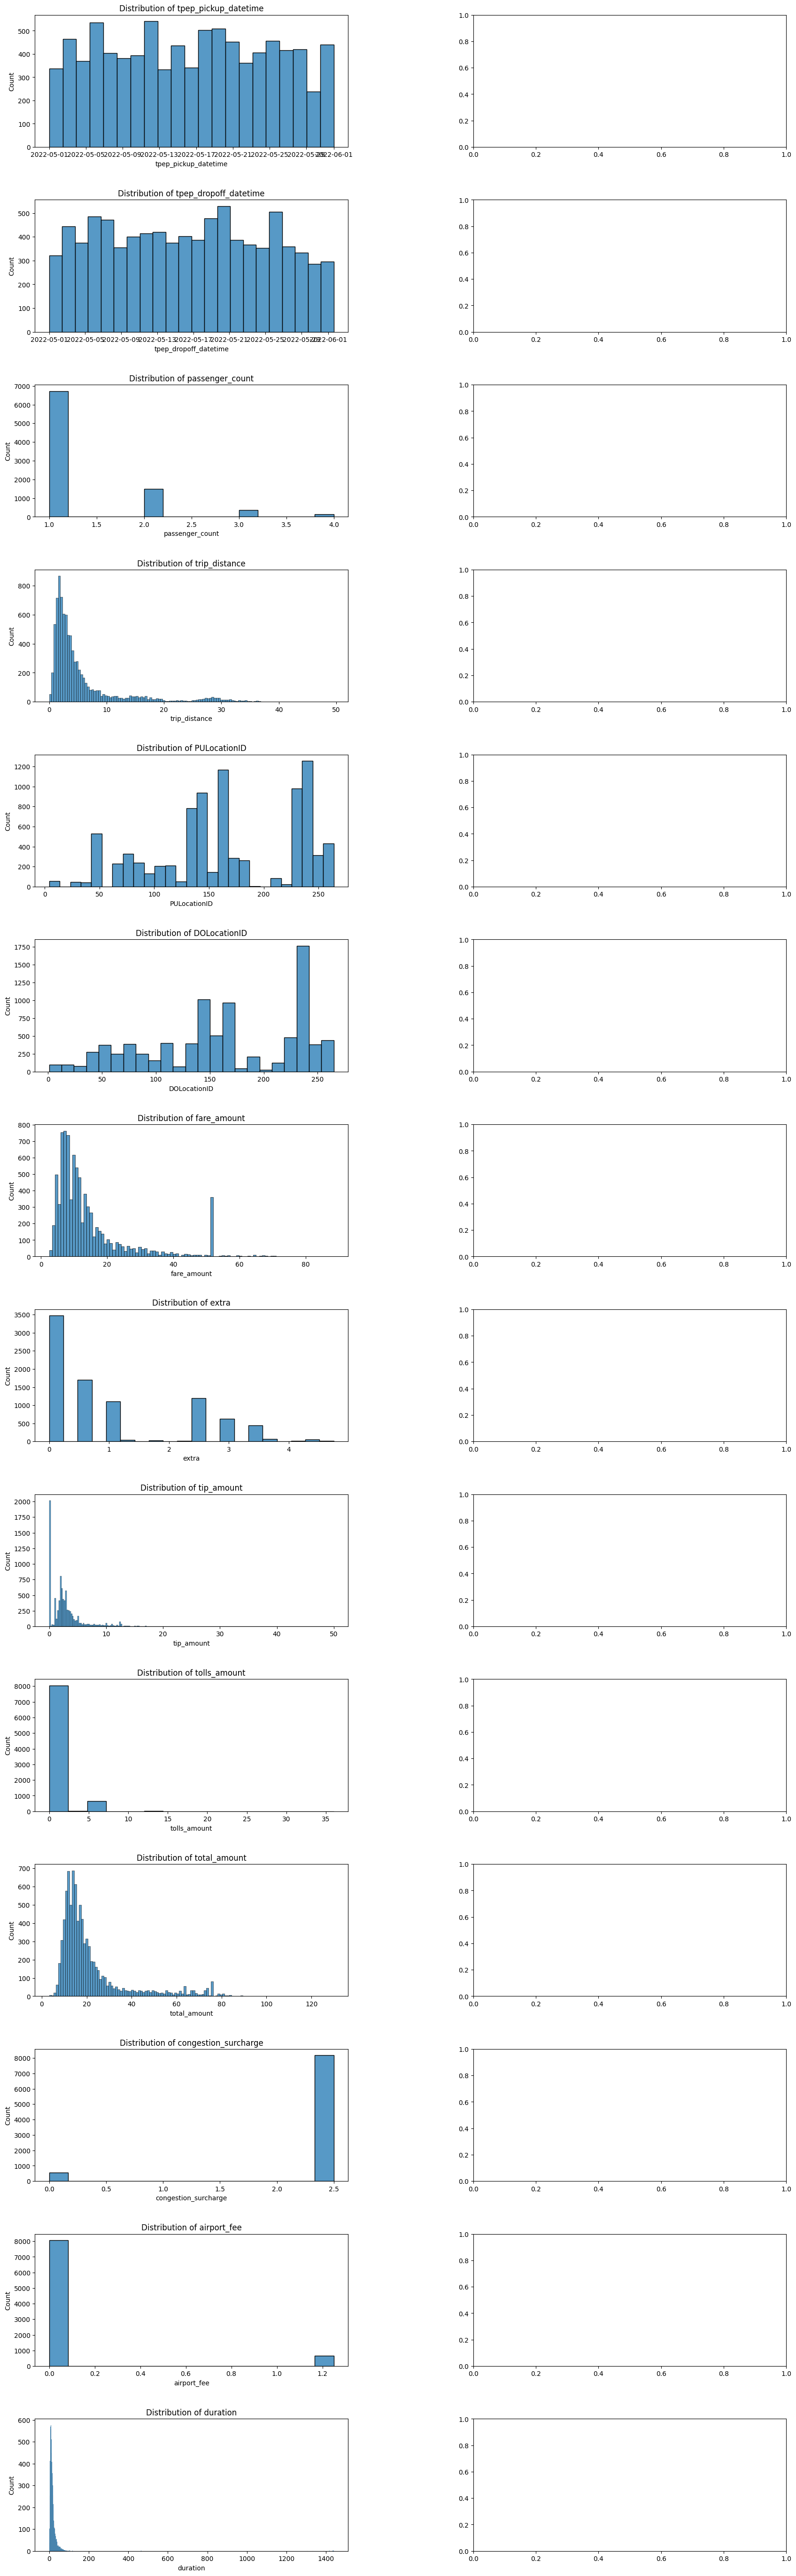

In [ ]:
columns = filtered_df.drop(
    ["PUZone", "DOZone", "PULat", "PULong", "DOLat", "DOLong"], axis=1
).columns
fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(20, 60))

for index, col in enumerate(columns):
    axes[index][0].set_title(f"Distribution of {col}")
    sns.histplot(x=filtered_df[col], ax=axes[index][0])
    # axes[index][1].set_title(f"Distribution of {col}")
    # sns.boxplot(x=filtered_df[col], ax=axes[index][1])

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=1, wspace=0.4, hspace=0.4)
plt.show()

#### Feature engineering: most congested zones and hours

To be able to assest the most congested zones and hours, it would be necessary to calculate the average speed on which the cabs transverse those zones and hours. THis will be perfomed using the trip distance infomation [km] and the duration of the trip [minutes].

In [ ]:
filtered_df["speed_minutes"] = filtered_df["trip_distance"] / filtered_df["duration"]

Now, we will subset the dataset to the trips made with a congestion surcharge and count the frecuency of each zone,

In [ ]:
df_congestion = filtered_df[filtered_df["congestion_surcharge"] > 0]
df_congestion["PUZone"].value_counts().sort_values(ascending=False).head(10)

PUZone
JFK Airport                  462
Upper East Side South        416
Midtown Center               361
Upper East Side North        308
Lincoln Square East          292
Murray Hill                  286
Midtown East                 278
Times Sq/Theatre District    266
Clinton East                 258
East Village                 248
Name: count, dtype: int64

Now, we will combine this congested zones information with the most frequent hours to know on which hours and zones are congested more frequently. 

In [ ]:
# Extract hour and minute components
df_congestion["hour_pickup"] = df_congestion["tpep_pickup_datetime"].dt.hour
df_congestion["minute_pickup"] = df_congestion["tpep_pickup_datetime"].dt.minute
df_congestion[["hour_pickup", "PUZone", "DOZone"]].groupby("DOZone").size().sort_values(
    ascending=False
).head(10)

/tmp/ipykernel_8530/2065270679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_congestion['hour_pickup'] = df_congestion['tpep_pickup_datetime'].dt.hour
/tmp/ipykernel_8530/2065270679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_congestion['minute_pickup'] = df_congestion['tpep_pickup_datetime'].dt.minute


DOZone                 hour_pickup  PUZone                       
Upper East Side North  15           Upper East Side South            41
                       17           Upper East Side South            38
                       16           Upper East Side South            30
East Village           19           Murray Hill                      29
Upper East Side South  17           Meatpacking/West Village West    29
East Chelsea           16           East Village                     29
Upper East Side South  17           JFK Airport                      28
Union Sq               18           Clinton East                     28
East Chelsea           18           East Village                     27
Upper East Side North  14           Upper East Side South            27
Name: count, dtype: int64

At this point we only need to know the average speed on the most congested drop off zones.

In [ ]:
average_speeds = df_congestion.groupby(["hour_pickup", "DOZone"])[
    "speed_minutes"
].mean()
worst_hours = average_speeds.sort_values(ascending=True)
worst_hours = pd.DataFrame(worst_hours).reset_index()
# From the worst hours we will select the worst 10%. They will constitute the worst of the worst.
q01 = worst_hours.speed_minutes.quantile(0.1)
worst_hours = worst_hours[worst_hours["speed_minutes"] <= q01]
worst_hours

hour_pickup                     DOZone  speed_minutes
0            18               Bloomingdale       0.019446
1            15           Prospect Heights       0.126000
2            21              South Jamaica       0.127992
3            18                 Ozone Park       0.136691
4            11                  Bay Ridge       0.137781
..          ...                        ...            ...
75           12        Lincoln Square East       0.218793
76           12      Upper West Side South       0.218947
77            8                Murray Hill       0.219185
78           12  West Chelsea/Hudson Yards       0.219801
79           15                       SoHo       0.220227

[80 rows x 3 columns]

Lastly, we will include this information in the filtered_df dataframe as a binary column, whith 0 representing not peak hour and 1 representing peak hour in the trip drop off zone. 

In [ ]:
filtered_df["hour_pickup"] = filtered_df["tpep_pickup_datetime"].dt.hour
filtered_df["minute_pickup"] = filtered_df["tpep_pickup_datetime"].dt.minute
filtered_df["day_pickup"] = filtered_df["tpep_pickup_datetime"].dt.day

In [ ]:
filtered_df["peak_hour"] = 0
# Iterate over each row in filtered_df
for index, row in filtered_df.iterrows():
    hour_pickup = row["hour_pickup"]
    dozone = row["DOZone"]

    # Check if hour_pickup and dozone exist in worst_hours
    if (
        worst_hours[
            (worst_hours["hour_pickup"] == hour_pickup)
            & (worst_hours["DOZone"] == dozone)
        ].shape[0]
        > 0
    ):
        filtered_df.at[index, "peak_hour"] = 1

In [ ]:
filtered_df["peak_hour"].value_counts()

peak_hour
0    7794
1     947
Name: count, dtype: int64

It's safe to assume that we wont use the datetime type of variables, so we drop them off the dataset.

In [ ]:
filtered_df = filtered_df.drop(
    ["tpep_pickup_datetime", "tpep_dropoff_datetime"], axis=1
)

### Geographical information: density heatmap and trip paths.

- Pick up passengers

In [ ]:
fig = px.density_mapbox(
    filtered_df,
    lat="PULat",
    lon="PULong",
    z="total_amount",
    radius=5,
    center=dict(lat=40.730610, lon=-73.935242),
    zoom=9,
    mapbox_style="stamen-terrain",
)
fig.show()

- Drop passengers

In [ ]:
fig = px.density_mapbox(
    filtered_df,
    lat="DOLat",
    lon="DOLong",
    z="total_amount",
    radius=5,
    center=dict(lat=40.730610, lon=-73.935242),
    zoom=9,
    mapbox_style="stamen-terrain",
)
fig.show()

In [ ]:
fig = px.density_mapbox(
    filtered_df,
    lat="PULat",
    lon="PULong",
    z="duration",
    radius=5,
    center=dict(lat=40.730610, lon=-73.935242),
    zoom=9,
    mapbox_style="stamen-terrain",
)
fig.show()

In [ ]:
fig = px.density_mapbox(
    filtered_df,
    lat="DOLat",
    lon="DOLong",
    z="duration",
    radius=5,
    center=dict(lat=40.730610, lon=-73.935242),
    zoom=9,
    mapbox_style="stamen-terrain",
)
fig.show()

- Trip Paths

In [ ]:
fig = px.line_mapbox(
    filtered_df, lat="PULat", lon="PULong", hover_name="PUZone", zoom=3, height=300
)
fig.add_trace(
    px.line_mapbox(
        filtered_df,
        lat="DOLat",
        lon="DOLong",
        hover_data=filtered_df[["DOZone", "trip_distance", "duration", "fare_amount"]],
    ).data[0]
)
fig.update_layout(
    mapbox_style="stamen-terrain",
    mapbox_zoom=9,
    mapbox_center_lat=40.7305,
    mapbox_center_lon=-73.93924,
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
)

fig.show()

Hovering over the graph drop off points, we noticed 4 zones located far away from NYC on which the fare amount, duration, and trip distances are abnormaly low. FIlter the dataframe of these observations it will enahance our predictive power.

In [ ]:
# Drop off the conflictive outliers zones
filtered_df = filtered_df[filtered_df["DOZone"] != "Norwood"]
filtered_df = filtered_df[filtered_df["DOZone"] != "Highbridge"]
filtered_df = filtered_df[filtered_df["DOZone"] != "Springfield Gardens North"]
filtered_df = filtered_df[filtered_df["DOZone"] != "Columbia Street"]

Text(0.5, 1.0, 'Fares ammount by hour')

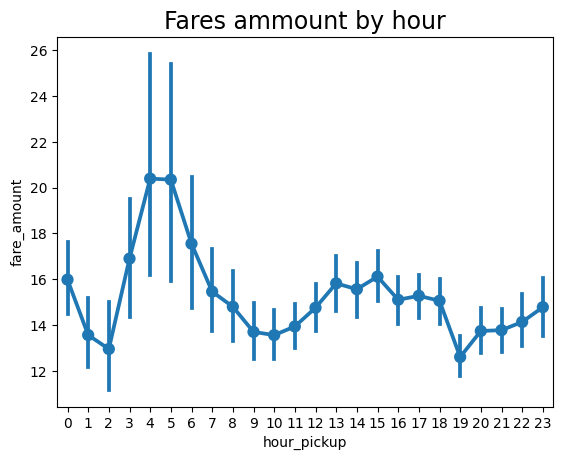

In [ ]:
sns.pointplot(x="hour_pickup", y="fare_amount", data=filtered_df, errorbar=("ci", 95))
plt.title("Fares ammount by hour", fontsize=17)

Text(0.5, 1.0, 'Speed by hour')

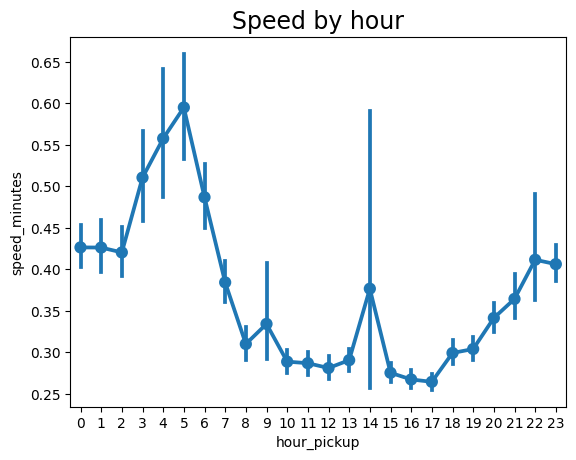

In [ ]:
sns.pointplot(x="hour_pickup", y="speed_minutes", data=filtered_df, errorbar=("ci", 95))
plt.title("Speed by hour", fontsize=17)

Text(0.5, 1.0, 'Fares amount by day')

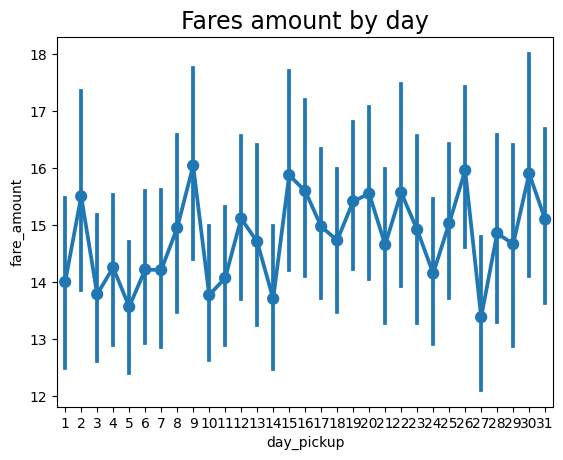

In [ ]:
sns.pointplot(x="day_pickup", y="fare_amount", data=filtered_df, errorbar=("ci", 95))
plt.title("Fares amount by day", fontsize=17)

### Zone encoder

With the aim to incorporate geographical information to our correlation matrix and predictive models, we will encode the pick up and drop off zones.

In [ ]:
encoder = LabelEncoder()
filtered_df["PUZone"] = encoder.fit_transform(filtered_df[["PUZone"]])

/home/asado/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
encoder = LabelEncoder()
filtered_df["DOZone"] = encoder.fit_transform(filtered_df[["DOZone"]])

/home/asado/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Linear correlation matrix

In [ ]:
df_numerics = filtered_df.drop(
    ["PUZone", "DOZone", "PULat", "PULong", "DOLat", "DOLong"], axis=1
)

<Axes: >

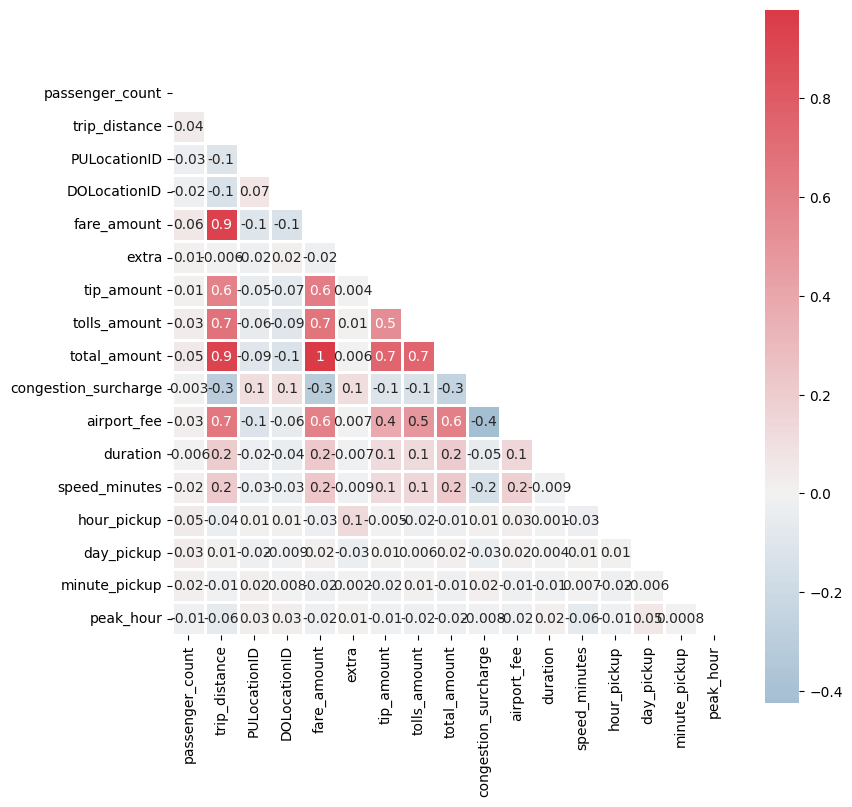

In [ ]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_numerics.corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    df_numerics.corr(),
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.8,
    annot=True,
    fmt=".1g",
)

In [ ]:
colinears_suspects = [
    "fare_amount",
    "total_amount",
    "trip_distance",
    "tip_amount",
    "tolls_amount",
    "airport_fee",
]

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# compute the vif for all given features
def compute_vif(considered_features):
    X = df_numerics[considered_features]
    # the calculation of variance inflation requires a constant
    X["intercept"] = 1

    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif["Variable"] != "intercept"]
    return vif

In [ ]:
compute_vif(colinears_suspects)

/tmp/ipykernel_6595/2069906272.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


Variable         VIF
0    fare_amount  254.713368
1   total_amount  429.367481
2  trip_distance    9.420232
3     tip_amount   17.630898
4   tolls_amount    8.919400
5    airport_fee    1.763820

As we see in the correlation plot and VIF calculations, there is a high multicollinearity between fare amount and total amount. It's adviced to pick one of these two and since fare amount is more feasible to estimate and thereby to predict (i.e we dont need to predict each and every single component of the total amount), we will drop total amount from our dataset.

In [ ]:
filtered_df = filtered_df.drop("total_amount", axis=1)

### Tran/val split and feature scaling.

In [ ]:
train_df, test_df = train_test_split(
    filtered_df, test_size=0.2, random_state=42, shuffle=True
)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(6985, 22)
(1747, 22)


### First model: linear regression

In [ ]:
X_train = train_df.drop("fare_amount", axis=1)
X_test = test_df.drop("fare_amount", axis=1)
y_train = train_df["fare_amount"]
y_test = test_df["fare_amount"]

In [ ]:
columns = X_train.columns
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

R square for linear explicability

In [ ]:
reg.score(X_train, y_train), reg.score(X_test, y_test)

(0.9985578893008981, 0.998625109627265)

In [ ]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

MSE for measuring performance

In [ ]:
mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)

(0.22440516764243443, 0.19603371935050287)

In [ ]:
mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)

(0.31560779014685825, 0.30400930361845657)

- LInear regression for duration variable

In [ ]:
X_train = train_df.drop("duration", axis=1)
X_test = test_df.drop("duration", axis=1)
y_train = train_df["duration"]
y_test = test_df["duration"]

In [ ]:
columns = X_train.columns
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train), reg.score(X_test, y_test)

(0.05457405529386772, 0.05645361621362255)

In [ ]:
mean_squared_error(y_train, reg.predict(X_train)), mean_squared_error(
    y_test, reg.predict(X_test)
)

(3324.3099432663116, 1202.0785773704247)

In [ ]:
mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)

(6.415076210289168, 4.684940550793266)

### Second model: XGRegression

In [ ]:
X_train = train_df.drop(["fare_amount", "total_amount"], axis=1)
X_test = test_df.drop(["fare_amount", "total_amount"], axis=1)
y_train = train_df["fare_amount"]
y_test = test_df["fare_amount"]

In [ ]:
columns = X_train.columns
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

- XGRegression for fare amount variable

In [ ]:
xgreg = XGBRegressor().fit(X_train, y_train)
xgreg.score(X_train, y_train), xgreg.score(X_test, y_test)

(0.9993888577105488, 0.9443820710385394)

In [ ]:
mean_squared_error(y_train, xgreg.predict(X_train)), mean_squared_error(
    y_test, xgreg.predict(X_test)
)

(0.0950991404495447, 7.930079148927598)

In [ ]:
mean_absolute_error(y_train, xgreg.predict(X_train)), mean_absolute_error(
    y_test, xgreg.predict(X_test)
)

(0.2162251714066087, 0.6978417810604923)

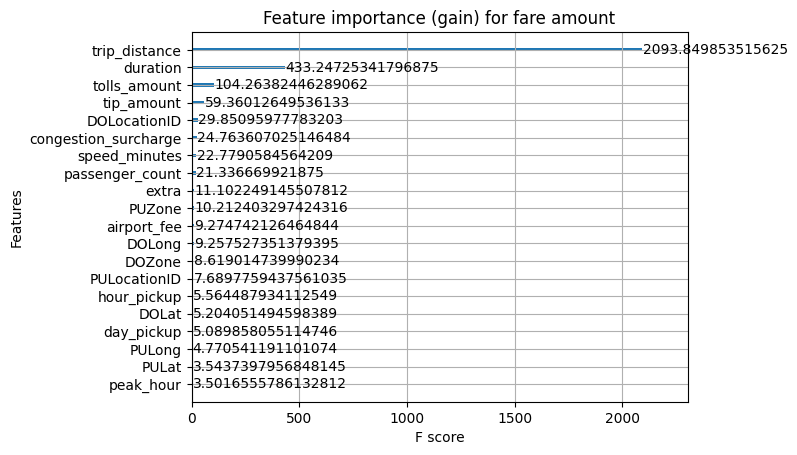

In [ ]:
plot_importance(
    xgreg, importance_type="gain", title="Feature importance (gain) for fare amount"
)
plt.show()

- XGRegression for duration variable

In [ ]:
X_train = train_df.drop("duration", axis=1)
X_test = test_df.drop("duration", axis=1)
y_train = train_df["duration"]
y_test = test_df["duration"]

In [ ]:
columns = X_train.columns
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

In [ ]:
xgreg = XGBRegressor()
xgreg.fit(X_train, y_train)
xgreg.score(X_train, y_train), xgreg.score(X_test, y_test)

(0.9999773559155145, 0.9989614641907696)

In [ ]:
mean_squared_error(y_train, xgreg.predict(X_train)), mean_squared_error(
    y_test, xgreg.predict(X_test)
)

(0.07962120738564248, 1.3230951541547327)

In [ ]:
mean_absolute_error(y_train, xgreg.predict(X_train)), mean_absolute_error(
    y_test, xgreg.predict(X_test)
)

(0.2080715252109631, 0.5076135185004657)

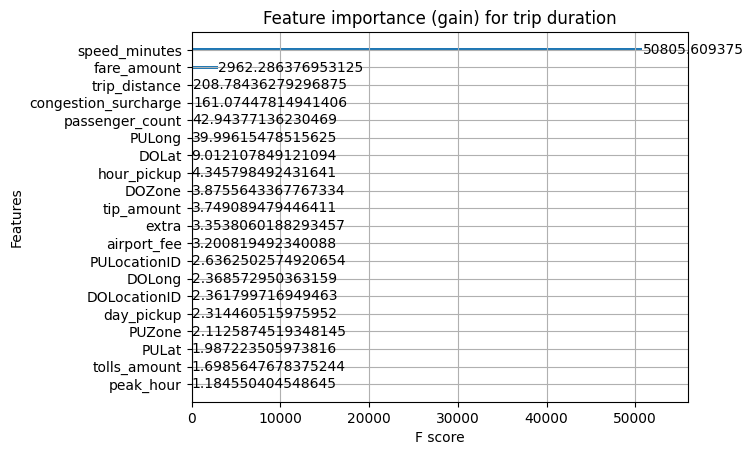

In [ ]:
plot_importance(
    xgreg, importance_type="gain", title="Feature importance (gain) for trip duration"
)
plt.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------

### Second model: restricted XGBoost

Ideally it would be neat if each individual user know the information for each and every one of 21 variables that the complete model have, but this is an impossible feature, so we will have to select the more important, in model gain termsl, and those who are easier to input. If the user select where and when want to make a taxi trip, we can estimate the distance, if there is a congestion surcharge, if it's necesary to charge an airpot fee and estimate the average speed. According to the feature importance graph, those would be useful to accurately predict the fare amount, which, in turn, would serve as the input for the duration model. 

- Restricted model for fare

In [ ]:
X_train = train_df[
    ["trip_distance", "congestion_surcharge", "speed_minutes", "airport_fee"]
]
X_test = test_df[
    ["trip_distance", "congestion_surcharge", "speed_minutes", "airport_fee"]
]
y_train = train_df["fare_amount"]
y_test = test_df["fare_amount"]

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
xgreg = XGBRegressor()
xgreg.fit(X_train, y_train)
xgreg.score(X_train, y_train), xgreg.score(X_test, y_test)

(0.9970798859769505, 0.9009064675495708)

In [ ]:
mean_squared_error(y_train, xgreg.predict(X_train)), mean_squared_error(
    y_test, xgreg.predict(X_test)
)

(0.45439554486734257, 14.12888919368514)

In [ ]:
mean_absolute_error(y_train, xgreg.predict(X_train)), mean_absolute_error(
    y_test, xgreg.predict(X_test)
)

(0.3462612575006724, 0.8295673831640548)

- Restricted model for duration

In [ ]:
X_train = train_df[
    ["speed_minutes", "trip_distance", "fare_amount", "congestion_surcharge"]
]
X_test = test_df[
    ["speed_minutes", "trip_distance", "fare_amount", "congestion_surcharge"]
]
y_train = train_df["duration"]
y_test = test_df["duration"]

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
xgreg = XGBRegressor()
xgreg.fit(X_train, y_train)
xgreg.score(X_train, y_train), xgreg.score(X_test, y_test)

(0.9999712281828983, 0.9992283828074127)

In [ ]:
mean_squared_error(y_train, xgreg.predict(X_train)), mean_squared_error(
    y_test, xgreg.predict(X_test)
)

(0.10116756178782943, 0.9830406995126637)

In [ ]:
mean_absolute_error(y_train, xgreg.predict(X_train)), mean_absolute_error(
    y_test, xgreg.predict(X_test)
)

(0.22851107160094122, 0.4384780855675595)

### Third model: XGBoost hyperparameters tunning

- For fare amount

In [ ]:
X_train = train_df[
    ["trip_distance", "congestion_surcharge", "speed_minutes", "airport_fee"]
]
X_test = test_df[
    ["trip_distance", "congestion_surcharge", "speed_minutes", "airport_fee"]
]
y_train = train_df["fare_amount"]
y_test = test_df["fare_amount"]

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
%%time
param_grid = {
    'max_depth': [10, 15, 20, 30],
    'colsample_bytree' : [0.25, 0.5, 0.7, 1],
    'min_child_weight': [50, 100, 300, 500],
    'learning_rate': [0.01, 0.02, 0.04, 0.08, 0.1]
}

xgb_gs = GridSearchCV(
    XGBRegressor(n_estimators = 20, early_stopping_rounds = 30, importance_type = 'gain'),
    param_grid,
    cv = 2,
    scoring = 'neg_root_mean_squared_error',
    verbose = 2
)
xgb_gs.fit(X_train, y_train, eval_set = [(X_test, y_test)])
best_params = xgb_gs.best_params_
print(xgb_gs.best_params_)

Fitting 2 folds for each of 320 candidates, totalling 640 fits
[0]	validation_0-rmse:17.99327
[1]	validation_0-rmse:17.82585
[2]	validation_0-rmse:17.66019
[3]	validation_0-rmse:17.49623
[4]	validation_0-rmse:17.33399
[5]	validation_0-rmse:17.17347
[6]	validation_0-rmse:17.01474
[7]	validation_0-rmse:16.85751
[8]	validation_0-rmse:16.70208
[9]	validation_0-rmse:16.54821
[10]	validation_0-rmse:16.39608
[11]	validation_0-rmse:16.24543
[12]	validation_0-rmse:16.09659
[13]	validation_0-rmse:15.94932
[14]	validation_0-rmse:15.80365
[15]	validation_0-rmse:15.65955
[16]	validation_0-rmse:15.51672
[17]	validation_0-rmse:15.37564
[18]	validation_0-rmse:15.23583
[19]	validation_0-rmse:15.09777
[CV] END colsample_bytree=0.25, learning_rate=0.01, max_depth=10, min_child_weight=50; total time=   2.9s
[0]	validation_0-rmse:17.99331
[1]	validation_0-rmse:17.82600
[2]	validation_0-rmse:17.66047
[3]	validation_0-rmse:17.49665
[4]	validation_0-rmse:17.33452
[5]	validation_0-rmse:17.17421
[6]	validation_

In [ ]:
xgreg = XGBRegressor(
    colsample_bytree=1, learning_rate=0.08, max_depth=10, min_child_weight=50
).fit(X_train, y_train)
xgreg.score(X_train, y_train), xgreg.score(X_test, y_test)

(0.9033698054851655, 0.8799115369418423)

In [ ]:
mean_squared_error(y_train, xgreg.predict(X_train)), mean_squared_error(
    y_test, xgreg.predict(X_test)
)

(14.980065168596566, 17.150104020759937)

In [ ]:
mean_absolute_error(y_train, xgreg.predict(X_train)), mean_absolute_error(
    y_test, xgreg.predict(X_test)
)

(1.9253970831022489, 1.9556654615680626)

- For duration

In [ ]:
X_train = train_df[
    ["speed_minutes", "trip_distance", "fare_amount", "congestion_surcharge"]
]
X_test = test_df[
    ["speed_minutes", "trip_distance", "fare_amount", "congestion_surcharge"]
]
y_train = train_df["duration"]
y_test = test_df["duration"]

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
%%time
param_grid = {
    'max_depth': [10, 15, 20, 30],
    'colsample_bytree' : [0.25, 0.5, 0.7, 1],
    'min_child_weight': [50, 100, 300, 500],
    'learning_rate': [0.01, 0.02, 0.04, 0.08, 0.1]
}

xgb_gs = GridSearchCV(
    XGBRegressor(n_estimators = 20, early_stopping_rounds = 30, importance_type = 'gain'),
    param_grid,
    cv = 2,
    scoring = 'neg_root_mean_squared_error',
    verbose = 2
)
xgb_gs.fit(X_train, y_train, eval_set = [(X_test, y_test)])
best_params = xgb_gs.best_params_
print(xgb_gs.best_params_)

Fitting 2 folds for each of 320 candidates, totalling 640 fits
[0]	validation_0-rmse:39.00455
[1]	validation_0-rmse:38.90803
[2]	validation_0-rmse:38.81350
[3]	validation_0-rmse:38.72100
[4]	validation_0-rmse:38.62772
[5]	validation_0-rmse:38.53620
[6]	validation_0-rmse:38.44833
[7]	validation_0-rmse:38.35970
[8]	validation_0-rmse:38.27490
[9]	validation_0-rmse:38.18912
[10]	validation_0-rmse:38.10496
[11]	validation_0-rmse:38.02429
[12]	validation_0-rmse:37.94539
[13]	validation_0-rmse:37.86502
[14]	validation_0-rmse:37.78877
[15]	validation_0-rmse:37.71099
[16]	validation_0-rmse:37.63469
[17]	validation_0-rmse:37.56235
[18]	validation_0-rmse:37.48848
[19]	validation_0-rmse:37.41604
[CV] END colsample_bytree=0.25, learning_rate=0.01, max_depth=10, min_child_weight=50; total time=   2.9s
[0]	validation_0-rmse:38.97500
[1]	validation_0-rmse:38.85047
[2]	validation_0-rmse:38.72957
[3]	validation_0-rmse:38.61223
[4]	validation_0-rmse:38.50745
[5]	validation_0-rmse:38.40472
[6]	validation_

In [ ]:
xgreg = XGBRegressor(
    colsample_bytree=1, learning_rate=0.1, max_depth=15, min_child_weight=50
).fit(X_train, y_train)
xgreg.score(X_train, y_train), xgreg.score(X_test, y_test)

(0.3496699272524957, -0.14733538641989297)

In [ ]:
mean_squared_error(y_train, xgreg.predict(X_train)), mean_squared_error(
    y_test, xgreg.predict(X_test)
)

(2286.692828079324, 1461.7058713529284)

In [ ]:
mean_absolute_error(y_train, xgreg.predict(X_train)), mean_absolute_error(
    y_test, xgreg.predict(X_test)
)

(4.500384933622548, 4.418461814142325)

----------------------------------------------------------------------------------------------------------------------------------------------------------

- Chequear si hay mas de un dropout zone por viaje (viajes compartidos). Googlear 